In [1]:
import os
import xarray as xr
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torch.optim import Adam 
from einops import rearrange
import tqdm

In [2]:
from denoising_diffusion_pytorch import Unet
from tc_data_loader import TC_xy_Dataset 
from tc_diff import Diffusion_model

/home/cw55/.conda/envs/tcdiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
timesteps = 300
batch_size = 32
results_folder = Path("./tc_test")

# Dataset

In [4]:
# training_data  = TC_xy_Dataset(data_dir='./dataset/tc_data',
#                                data_vars=['slp','u_ref','v_ref','precip'],
#                                years=[120,121])
training_data  = TC_xy_Dataset(data_dir='./dataset/tc_data',
                               data_vars=['slp'],
                               years=[120,121,122,123,124])

var slp year 120: length 3919 
var slp year 121: length 3878 
var slp year 122: length 4573 
var slp year 123: length 4823 
var slp year 124: length 3718 


In [5]:
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
dataloader = train_loader
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Train the model 

In [6]:
# diffusion model
tc_diff_model = Diffusion_model(timesteps)

In [7]:
# decoder model
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = training_data.data.shape[-1]
channels = training_data.data.shape[1]
 
model = Unet(
    dim = 16,
    channels=channels,
    dim_mults = (1, 2, 4, 8 ), 
    resnet_block_groups = 4,
    flash_attn = False
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

2439457

In [9]:
epochs = 4

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        loss = tc_diff_model.p_losses(model, batch, t, loss_type="huber")
        # loss_val = tc_diff_model.p_losses(model, batch, t, loss_type="huber")
        if step % 100 == 0:
            print(f"epoch: {epoch:02d} |step: {step:03d} | Loss: {loss.item():7.4f}" )
            
        loss.backward()
        optimizer.step()

    #save generated images  each epoch
    milestone = epoch
    all_images = tc_diff_model.sample(model, image_size, batch_size=36, channels=channels)[-1]
    all_images = (all_images + 1) * 0.5
    all_images = make_grid(torch.tensor(all_images), nrow = 6)
    save_image(all_images, str(results_folder / f'sample-{milestone}.png'))

epoch: 00 |step: 000 | Loss:  0.4413
epoch: 00 |step: 100 | Loss:  0.0109
epoch: 00 |step: 200 | Loss:  0.0056
epoch: 00 |step: 300 | Loss:  0.0056
epoch: 00 |step: 400 | Loss:  0.0087
epoch: 00 |step: 500 | Loss:  0.0056
epoch: 00 |step: 600 | Loss:  0.0036


sampling loop time step: 100%|██████████| 300/300 [00:18<00:00, 16.53it/s]


epoch: 01 |step: 000 | Loss:  0.0059
epoch: 01 |step: 100 | Loss:  0.0026
epoch: 01 |step: 200 | Loss:  0.0039
epoch: 01 |step: 300 | Loss:  0.0028
epoch: 01 |step: 400 | Loss:  0.0035
epoch: 01 |step: 500 | Loss:  0.0032
epoch: 01 |step: 600 | Loss:  0.0041


sampling loop time step: 100%|██████████| 300/300 [00:18<00:00, 16.60it/s]


epoch: 02 |step: 000 | Loss:  0.0032
epoch: 02 |step: 100 | Loss:  0.0039
epoch: 02 |step: 200 | Loss:  0.0027
epoch: 02 |step: 300 | Loss:  0.0047
epoch: 02 |step: 400 | Loss:  0.0018
epoch: 02 |step: 500 | Loss:  0.0052
epoch: 02 |step: 600 | Loss:  0.0027


sampling loop time step: 100%|██████████| 300/300 [00:17<00:00, 16.73it/s]


epoch: 03 |step: 000 | Loss:  0.0060
epoch: 03 |step: 100 | Loss:  0.0028
epoch: 03 |step: 200 | Loss:  0.0025
epoch: 03 |step: 300 | Loss:  0.0032
epoch: 03 |step: 400 | Loss:  0.0038
epoch: 03 |step: 500 | Loss:  0.0047
epoch: 03 |step: 600 | Loss:  0.0054


sampling loop time step: 100%|██████████| 300/300 [00:18<00:00, 16.30it/s]


# Sampling (inference)

In [10]:
# sample 64 images
sample_batch_size = 256 
samples = tc_diff_model.sample(model, image_size=image_size, batch_size=sample_batch_size, channels=channels)

sampling loop time step: 100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


In [11]:
np.array(samples).shape

(300, 256, 1, 80, 80)

In [12]:
# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    
    num_rows = len(imgs) 
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(10,3), dpi = 200, nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx] 
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, a0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    

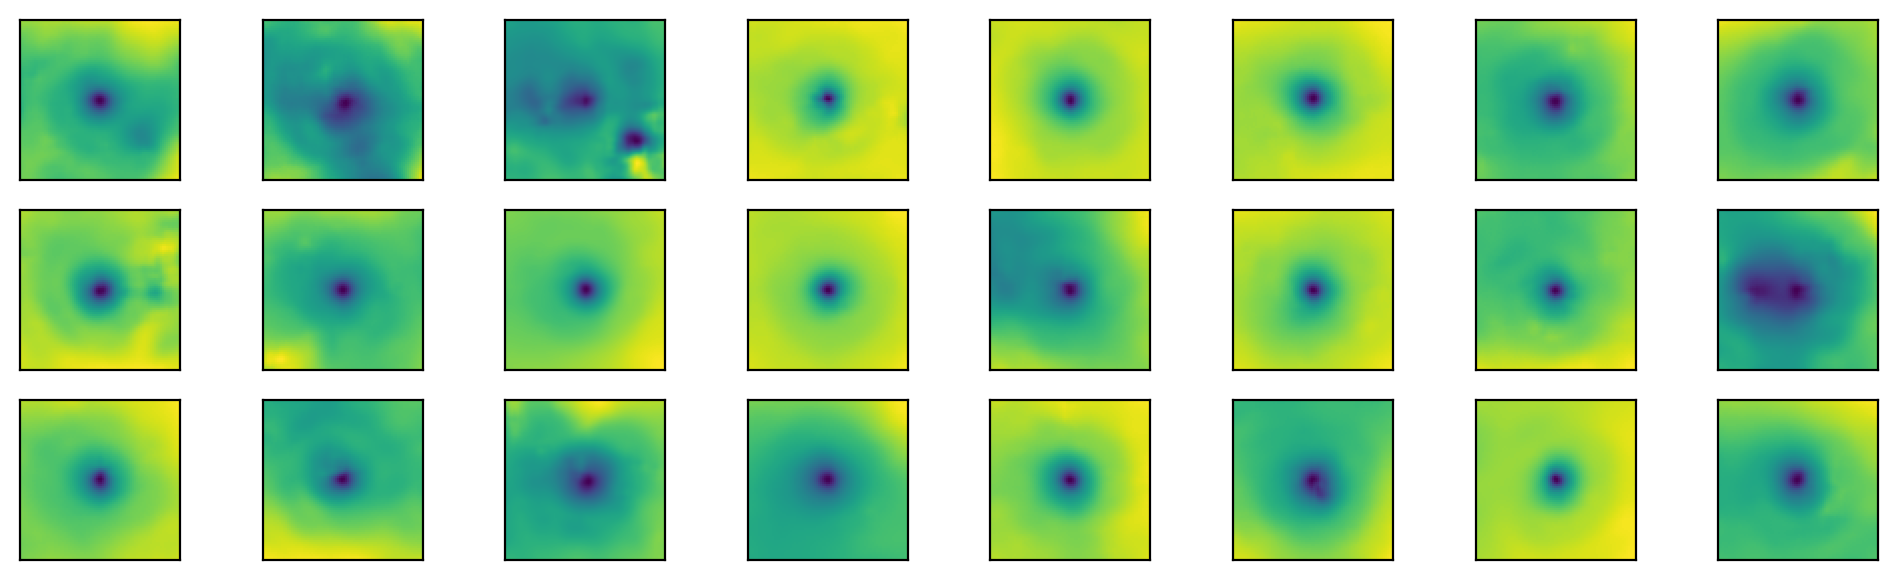

In [13]:
model_samples = [samples[-1][_] for _ in range(sample_batch_size)]
# unnorm
model_samples = training_data.unnormalization(np.array(model_samples))
model_samples_plot = rearrange(model_samples[:24], '(br bc) c h w -> br bc h w c', br=3)
plot(model_samples_plot)

In [14]:
model_samples.max(),model_samples.min(),model_samples.max()-model_samples.min()

(1026.0322, 975.8248, 50.207397)

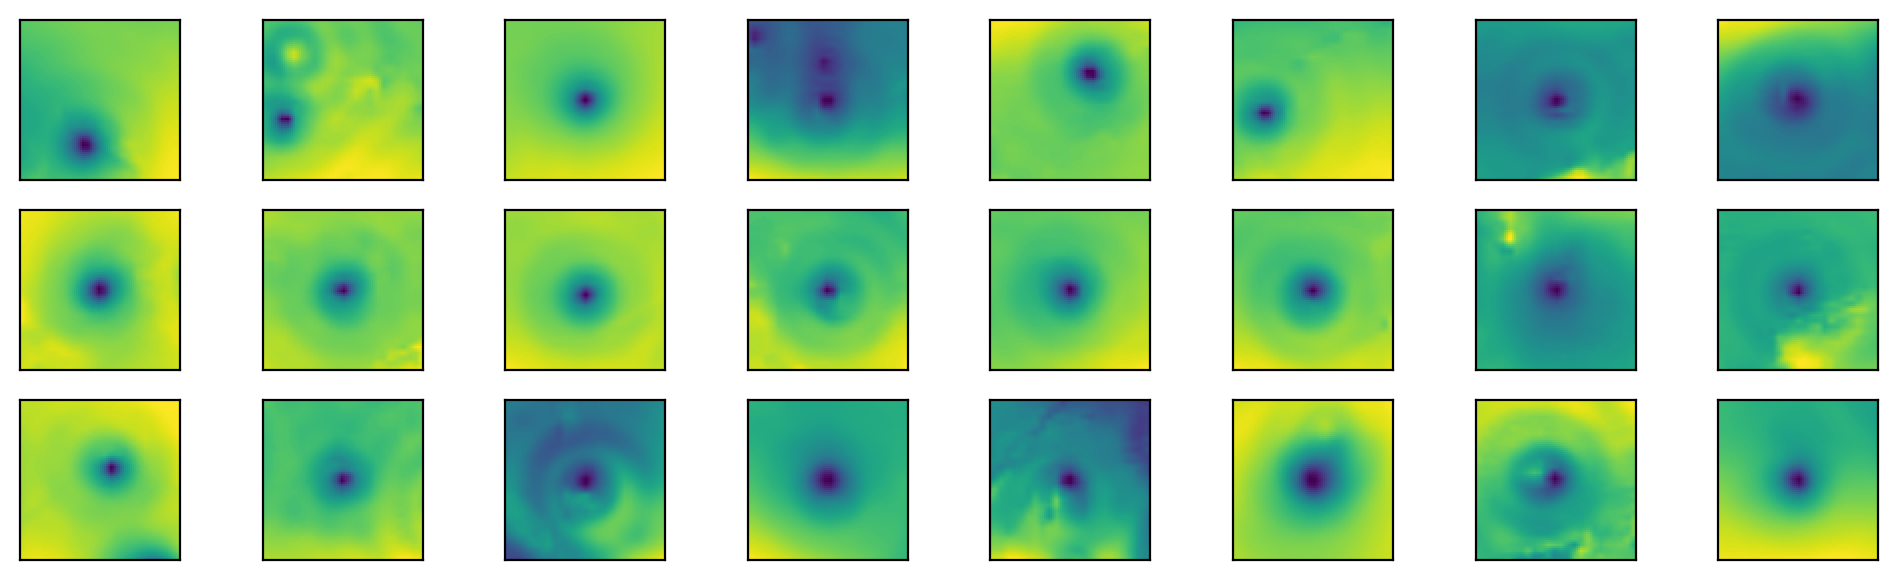

In [15]:
# trainning data samples
training_samples = training_data.data[np.random.randint(0,len(training_data),sample_batch_size)] 
training_samples = training_data.unnormalization(training_samples)
training_samples_plot = rearrange(training_samples[:24], '(br bc) c h w -> br bc h w c', br=3)
plot(training_samples_plot)

(array([5.00000e+00, 1.10000e+01, 1.10000e+01, 1.90000e+01, 3.60000e+01,
        5.50000e+01, 1.17000e+02, 2.10000e+02, 3.51000e+02, 6.12000e+02,
        1.02300e+03, 1.90700e+03, 4.03000e+03, 1.02240e+04, 2.37410e+04,
        6.59250e+04, 2.29249e+05, 5.73742e+05, 5.57399e+05, 1.43364e+05,
        2.52180e+04, 1.14800e+03, 0.00000e+00, 0.00000e+00]),
 array([ 920.,  925.,  930.,  935.,  940.,  945.,  950.,  955.,  960.,
         965.,  970.,  975.,  980.,  985.,  990.,  995., 1000., 1005.,
        1010., 1015., 1020., 1025., 1030., 1035., 1040.]),
 <BarContainer object of 24 artists>)

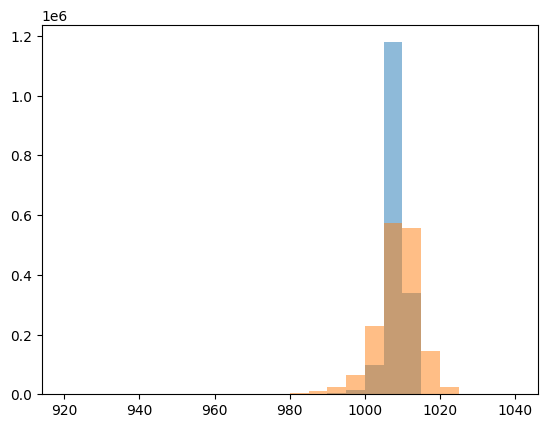

In [17]:
plt.hist(model_samples.flatten(),bins=np.arange(920,1041,5),alpha=0.5)
plt.hist(training_samples.flatten(),bins=np.arange(920,1041,5),alpha=0.5)